# Project Description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it is discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

## Interconnect's Services

Interconnect mainly provides two types of service:
 - Landline communication: the telephone can be connected to several lines simultaneously.
 - Internet: the network can be set up via a telephone line or through a fiber optic cable.
 
Some other services the company provides:
 - Internet security: antivirus software (`'DeviceProtection'`) and a malicious website blocker (`'OnlineSecurity'`)
 - Dedicated technical support line (`'TechSupport'`)
 - Cloud file storage and data backup (`'OnlineBackup'`)
 - TV streaming (`'StreamingTV'`) and a movie directory (`'StreamingMovies'`)
 
The clients can choose either a monthly payment or sign a one- or two-year contract. Clients can use various payment methods and recieve an electronic invoice after a transaction. 

## Description of the Data

**The data consists of files obtained from different sources:**
 - contact.csv - contract information
 - personal.csv - client's personal data
 - internet.csv - information about internet services
 - phone.csv - information about telephone services
 
In each file the column `'customerID'` contains a unique code assigned to each client.

 
**The following is a complete list of values from all of the data files:**
 - `'customerID'` - Unique ID
 - `'gender'` - Gender
 - `'SeniorCitizen'` - Whether senior citizen or not
 - `'Partner'` - Has partner or not
 - `'Dependents'` - Number of dependents
 - `'BeginDate'` - Joining date
 - `'EndDate'` - Ending date
 - `'Type'` - Plan type
 - `'PaperlessBilling'` - Type of paperpless billing
 - `'PaymentMethod'` - Payment method
 - `'MonthlyCharges'` - Monthly charges
 - `'TotalCharges'` - Total charges
 - `'MultipleLines'` - Whether has multiple lines
 - `'InternetService'` - Whether has internet service
 - `'OnlineSecurity'` - Whether has online security
 - `'OnlineBackup'` - Whether has online backup
 - `'DeviceProtection'` - Whether has device protection
 - `'TechSupport'` - Whether has tech support
 - `'StreamingTV'` - Whether has streaming TV
 - `'StreamingMovies'` - Whether has streaming movies
 - `'is_churned'` - Whether churned
 - `'num_days'` - Number of days in the system
 - `'year'` - Year
 - `'num_services'` - Number of services availed

## Work Plan

1. Explore the data to understand which segment of the customers have churned.
     - Exploratory analysis around gender, senior citizen and characteristics of the customers have revealed some useful insights into this question.
2. Join all the datasets using the CustomerId by making a left join with personal data. This is required for modeling.
3. There are 2 ways to fill the missing values:
     - For TotalCharges, try to infer the missing values using `'MonthlyCharges'` and `'BeginDate'`. For the phone and internet data, you could use mode to fill the missing value.
     - Build a Logistic Regression model to populate the missing values one by one to avoid any bias.
4. For feature engineering, create few features:
     - Number of days between `'EndDate'` and `'BeginDate'`. For active customers use 2020-02-01 as the end date.
     - Calculate the number of payments made using `'MonthlyCharges'` and `'TotalCharges'`.
     - Create date features from `'BeginDate'` such as `'year'`, `'month'`, `'day'` and `'dayofweek'`.
5. For modeling:
     - Convert all the boolean features using One Hot encoding. For `'Type'` and `'PaymentMethods'` use Ordinal encoding. Change the data types after conversion to reduce the data size.
     - Drop redundant features such as `'CustomerId'`, `'BeginDate'` and `'EndDate'`.
     - Stratify and split the datasets into train, valid and test. Use the test set only once with each model.
     - For the imbalance use the class_weights argument available in the respective models that will be used. Or maybe upsampling the under represented class.
     - Use 5-fold cross validation with gridsearch to find good hyperparameters.
     - Create a base model. Additionally create 3 models: LogisticRegression, RandomForestClassifier and CatBoostClassifier to pick the best performing model.

## Solution Code

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
print('Shape of contract:', contract.shape)
print('Shape of personal:', personal.shape)
print('Shape of internet:', internet.shape)
print('Shape of phone:', phone.shape)

Shape of contract: (7043, 8)
Shape of personal: (7043, 5)
Shape of internet: (5517, 8)
Shape of phone: (6361, 2)


In [4]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
# merging the dataframes

all_df = personal.merge(contract, left_on=['customerID'], right_on=['customerID'], how='left')
all_df = all_df.merge(phone, left_on=['customerID'], right_on=['customerID'], how='left')
all_df = all_df.merge(internet, left_on=['customerID'], right_on=['customerID'], how='left')

### Changing the Datatypes
 - `'BeginDate'`
 - `'EndDate'`
 - `'TotalCharges'`

In [6]:
all_df['BeginDate'] = pd.to_datetime(all_df['BeginDate'], format='%Y-%m-%d')
all_df['EndDate'] = pd.to_datetime(all_df['EndDate'], format='%Y-%m-%d', errors='coerce')

In [7]:
all_df['TotalCharges'] = all_df['TotalCharges'].replace(" ", np.nan).astype(np.float32)

In [8]:
all_df['is_churned'] = all_df['EndDate'].apply(lambda x: 0 if pd.isna(x) else 1)

### Add Features
 - `'num_days'` = `'EndDate'` - `'BeginDate'`
 - `'num_payments'` = `'TotalCharges'` - `'MonthlyCharges'`
 - `'year'` = year(`'BeginDate'`)
 - `'num_services'` = sum(`'MulitpleLines'`) + sum(all internet services)

In [9]:
all_df['num_days'] = (
    all_df[['EndDate', 
            'BeginDate']]
            .apply(lambda x: datetime.datetime.strptime('2020-02-01', '%Y-%m-%d') - x[1] 
                   if pd.isna(x[0]) 
                   else x[0] - x[1], axis=1
                  )
).dt.days

In [10]:
all_df['year'] = all_df['BeginDate'].dt.year

In [11]:
fill_na_cols = all_df.isnull().sum() > 0
fill_na_cols = fill_na_cols[fill_na_cols.values].index.drop(['EndDate', 'TotalCharges'])
temp_df = all_df[fill_na_cols].copy(deep=True)
for col in temp_df.columns:
    temp_df[col] = temp_df[col].apply(lambda x: 0 if x == 'No' else 1)
all_df['num_services'] = temp_df.sum(axis=1)

### Fill in Missing Values for `'MultipleLines'` and `'InternetServices'`
Not all of the customers have signed up for every services, therefore we will replace missing values in these columns with 'No'.

In [12]:
all_df.isnull().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
is_churned             0
num_days               0
year                   0
num_services           0
dtype: int64

In [13]:
for col in fill_na_cols:
    all_df[col] = all_df[col].fillna('No')

In [14]:
all_df.isnull().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
is_churned             0
num_days               0
year                   0
num_services           0
dtype: int64

### Split the Data

In [15]:
num_col_to_impute = ['TotalCharges']
cat_col_to_impute = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies']
col_to_drop = ['BeginDate', 'EndDate', 'customerID']
col_to_drop2 = ['BeginDate', 'EndDate', 'customerID', 'num_days']

In [16]:
# dataset with num_days

train_X, test_X = train_test_split(all_df.drop(col_to_drop, axis=1), 
                                                    stratify=all_df['is_churned'], 
                random_state=42, test_size=0.2)

In [17]:
train_X.shape, test_X.shape

((5634, 21), (1409, 21))

In [18]:
# dataset with num_days

train_X2, test_X2 = train_test_split(all_df.drop(col_to_drop2, axis=1), 
                                                    stratify=all_df['is_churned'], 
                random_state=42, test_size=0.1)

In [19]:
train_X2.shape, test_X2.shape

((6338, 20), (705, 20))

### Imput the Missing Categorical and Numerical Features

In [20]:
# before impute mean and median for TotalCharges

train_X['TotalCharges'].mean(), train_X['TotalCharges'].median()

(2302.6042, 1398.125)

In [21]:
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
num_imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')

In [22]:
train_X[num_col_to_impute] = num_imputer.fit_transform(train_X[num_col_to_impute])
train_X2[num_col_to_impute] = num_imputer2.fit_transform(train_X2[num_col_to_impute])

In [23]:
test_X[num_col_to_impute] = num_imputer.transform(test_X[num_col_to_impute])
test_X2[num_col_to_impute] = num_imputer2.transform(test_X2[num_col_to_impute])

In [24]:
# mean after imputing TotalCharges

train_X['TotalCharges'].mean(), train_X['TotalCharges'].median()

(2301.3199505648545, 1398.125)

In [25]:
# check missing
train_X2.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
is_churned          0
year                0
num_services        0
dtype: int64

In [26]:
# create a new feature number of payments post imputation

train_X['num_pmt'] = train_X['TotalCharges'] / train_X['MonthlyCharges']
test_X['num_pmt'] = test_X['TotalCharges'] / test_X['MonthlyCharges']

train_X2['num_pmt'] = train_X2['TotalCharges'] / train_X2['MonthlyCharges']
test_X2['num_pmt'] = test_X2['TotalCharges'] / test_X2['MonthlyCharges']

### Standard Scaler

In [27]:
std = StandardScaler()
std2 = StandardScaler()

In [28]:
train_X[['MonthlyCharges', 
         'TotalCharges', 
        'num_pmt',
        'year',
        ]] = std.fit_transform(train_X[['MonthlyCharges', 
                                                   'TotalCharges', 
                                                   'num_pmt',
                                                  'year',
                                       ]])

train_X2[['MonthlyCharges', 
         'TotalCharges', 
        'num_pmt',
        'num_services',  
        'year',
         ]] = std2.fit_transform(train_X2[['MonthlyCharges', 
                                                   'TotalCharges', 
                                                   'num_pmt',
                                                   'num_services',
                                                  'year',
                                          ]])

In [29]:
test_X[['MonthlyCharges', 
        'TotalCharges',
       'num_pmt',
        'year',
       ]] = std.transform(test_X[['MonthlyCharges', 
                                              'TotalCharges', 
                                              'num_pmt',
                                              'year',
                                 ]])

test_X2[['MonthlyCharges', 
        'TotalCharges',
        'num_pmt', 
        'num_services', 
        'year',
        ]] = std2.transform(test_X2[['MonthlyCharges', 
                                              'TotalCharges', 
                                              'num_pmt',
                                              'num_services',
                                              'year',
                                    ]])

### Ordinal Encoding

In [30]:
oe = OrdinalEncoder()
oe2 = OrdinalEncoder()

In [31]:
train_X[['Type', 'PaymentMethod']] = oe.fit_transform(train_X[['Type', 'PaymentMethod']])

In [32]:
test_X[['Type', 'PaymentMethod']] = oe.transform(test_X[['Type', 'PaymentMethod']])

In [33]:
train_X['SeniorCitizen'] = train_X['SeniorCitizen'].astype(str)
test_X['SeniorCitizen'] = test_X['SeniorCitizen'].astype(str)

train_X2['SeniorCitizen'] = train_X2['SeniorCitizen'].astype(str)
test_X2['SeniorCitizen'] = test_X2['SeniorCitizen'].astype(str)

In [34]:
cols_to_dummify = train_X.select_dtypes(include=['object']).columns.tolist()
train_X = pd.concat([train_X, pd.get_dummies(train_X[cols_to_dummify], drop_first=True)], axis=1)
test_X = pd.concat([test_X, pd.get_dummies(test_X[cols_to_dummify], drop_first=True)], axis=1)

cols_to_dummify = train_X2.select_dtypes(include=['object']).columns.tolist()
train_X2 = pd.concat([train_X2, pd.get_dummies(train_X2[cols_to_dummify], drop_first=True)], axis=1)
test_X2 = pd.concat([test_X2, pd.get_dummies(test_X2[cols_to_dummify], drop_first=True)], axis=1)

In [35]:
# drop the columns that are dummified

train_X = train_X.drop(cols_to_dummify, axis=1)
test_X = test_X.drop(cols_to_dummify, axis=1)

train_X2 = train_X2.drop(cols_to_dummify, axis=1)
test_X2 = test_X2.drop(cols_to_dummify, axis=1)

In [36]:
train_X.shape, test_X.shape

((5634, 21), (1409, 21))

In [37]:
train_X2.head()

,MonthlyCharges,TotalCharges,is_churned,year,num_services,num_pmt,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
5769,1.467403,2.375422,0,-1.466503,1.022701,1.545461,0,0,1,1,...,0,1,1,0,1,1,1,0,1,1
1834,-0.651857,-0.984239,1,1.072199,-1.847081,-1.274573,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3168,-1.505862,-0.548485,0,-0.958763,1.022701,0.857391,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4205,0.459179,-0.189591,0,0.564459,0.544404,-0.359101,0,0,1,1,...,0,1,0,0,1,0,1,0,1,1
6218,-0.210759,0.810143,0,-1.466503,1.022701,1.551114,0,0,1,1,...,0,0,0,0,0,1,1,1,1,1


In [38]:
train_X2.shape, test_X2.shape

((6338, 25), (705, 25))

### Evaluation Metric

In [39]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)

### Custom AUC ROC

In [40]:
def roc_auc_scorer(y_true, y_pred):
    """
    Use the customer scorer for roc_auc_score
    inside GridSearch
    """
    return roc_auc_score(y_true, y_pred)

In [41]:
roc_scorer = make_scorer(roc_auc_scorer, needs_threshold=True)

### Deal with Class Imbalance

In [42]:
def sampling(X, y, upsample=True, size=2):
    """
    Upsample or downsample either the
    under represented class or the over
    represented class to balance the classes
    """
    np.random.seed(42)
    target = None
    
    if not isinstance(y, np.ndarray):
        target = y.values
    else:
        target = y
    y_pos = np.where(target == 1)[0]
    y_neg = np.where(target == 0)[0]
    X_pos = X[target == 1]
    X_neg = X[target == 0]
    if upsample:
        idx = np.random.choice(y_pos, size=int(len(y_pos)*size))
        if not isinstance(y, np.ndarray):
            X = pd.concat([X.iloc[idx], X_neg])
        else:
            X = np.concatenate([X[idx], X_neg])
        y = np.concatenate([target[idx], target[y_neg]])
        
    else:
        idx = np.random.choice(y_neg, size=int(len(y_neg)*size))
        if not isinstance(y, np.ndarray):
            X = pd.concat([X.iloc[idx], X_pos])
        else:
            X = np.concatenate([X[idx], X_pos])
        y = np.concatenate([target[idx], target[y_pos]])
    return shuffle(X, y)

### Modeling

In [43]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict_proba(train_X)[:, 1]
        best_score = roc_auc_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'cat':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict_proba(test_X)[:, 1]
    best_score = roc_auc_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

In [44]:
target = 'is_churned'
features_train, target_train = train_X.drop([target], axis=1), train_X[target]
features_test, target_test = test_X.drop([target], axis=1), test_X[target]

features_train2, target_train2 = train_X2.drop([target], axis=1), train_X2[target]
features_test2, target_test2 = test_X2.drop([target], axis=1), test_X2[target]

In [45]:
# upsample the unrepresented class for the dataset without leakage

features_train2, target_train2 = sampling(train_X2.drop([target], axis=1), train_X2[target], upsample=True, size=1)

In [46]:
# shapes

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((5634, 20), (5634,), (1409, 20), (1409,))

In [47]:
# shapes train2

features_train2.shape, target_train2.shape, features_test2.shape, target_test2.shape

((6338, 24), (6338,), (705, 24), (705,))

In [48]:
# features to train with target leakage

features_train.head()

,MonthlyCharges,TotalCharges,num_days,year,num_services,num_pmt,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
3738,-0.521976,-0.263290,1067,0.065426,5,0.082725,1,0,0,0,0,0,0,0,0,0,1,0,1,1
3151,0.337478,-0.504815,457,0.572459,2,-0.700269,1,0,1,1,0,0,1,0,1,0,0,0,0,0
4860,-0.809013,-0.751214,396,1.079491,5,-0.731787,1,0,1,1,0,0,0,0,1,1,0,1,0,0
3867,0.284384,-0.173700,792,0.065426,5,-0.269408,0,0,1,0,1,0,0,0,0,1,1,0,1,1
3810,-0.676279,-0.990851,31,1.586524,1,-1.283201,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [49]:
# features to train without target leakage

features_train2.head()

,MonthlyCharges,TotalCharges,year,num_services,num_pmt,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
1057,0.661487,-0.637123,0.564459,-0.890487,-0.915474,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0
5621,0.331493,-0.902902,1.072199,-1.368784,-1.190318,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
885,-1.482646,-0.995289,1.579940,1.022701,-1.274573,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1017,-1.338377,-0.297857,-1.466503,1.500998,1.355451,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
4176,-1.490938,-0.853147,0.564459,1.022701,-0.611689,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0


In [50]:
# distribution is similar to the overall dataset

target_train.value_counts(normalize=True)

0    0.734647
1    0.265353
Name: is_churned, dtype: float64

### Dummy Model

In [51]:
dc = DummyClassifier()
best_dc_model, best_dc_auc, best_dc_time = build_model(dc, features_train, target_train, 
                                                        features_test, target_test,
                                                        hyperparameters={}, 
                scoring=roc_scorer, cv=2, model_str='dummy')

          train  test
Accuracy   0.73  0.73
F1         0.00  0.00
APS        0.27  0.27
ROC AUC    0.50  0.50


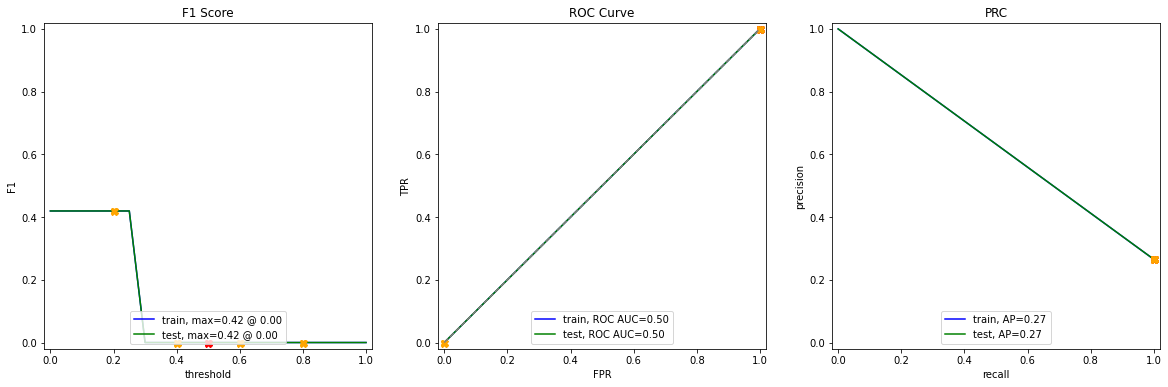

In [52]:
evaluate_model(best_dc_model, features_train, target_train, 
                                    features_test, target_test)

### LogisticRegression Without Target Leakage

In [53]:
lr2 = LogisticRegression(class_weight='balanced', random_state=42)
best_lr2_model, best_lr2_auc, best_lr2_time = build_model(lr2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'C' : [.001, .01, .1, 1, 10]}, 
                scoring=roc_scorer, cv=5)

          train  test
Accuracy   0.80  0.81
F1         0.69  0.70
APS        0.76  0.80
ROC AUC    0.89  0.91


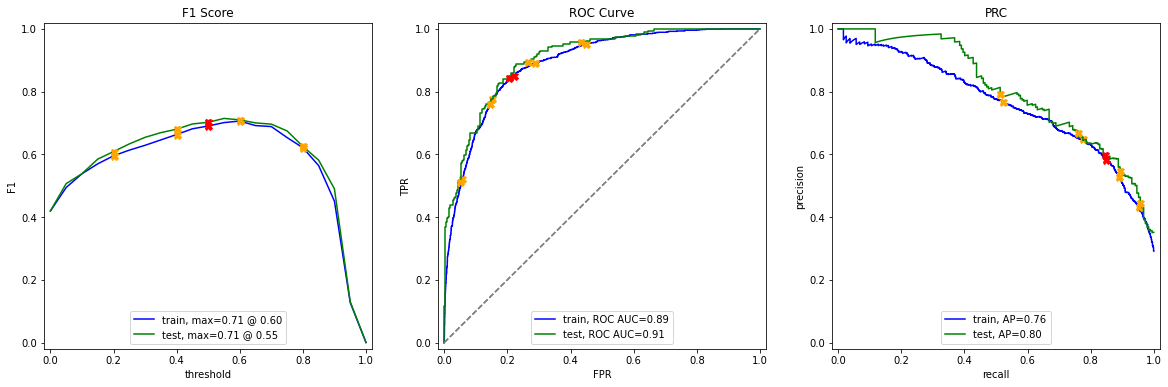

In [54]:
evaluate_model(best_lr2_model, features_train2, target_train2, 
                            features_test2, target_test2)

### RandomForestClassifier Without Leakage

In [55]:
rf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=50, random_state=42)
best_rf2_model, best_rf2_auc, best_rf2_time = build_model(rf2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=roc_scorer, cv=5)

          train  test
Accuracy   0.80  0.80
F1         0.69  0.66
APS        0.76  0.71
ROC AUC    0.89  0.87


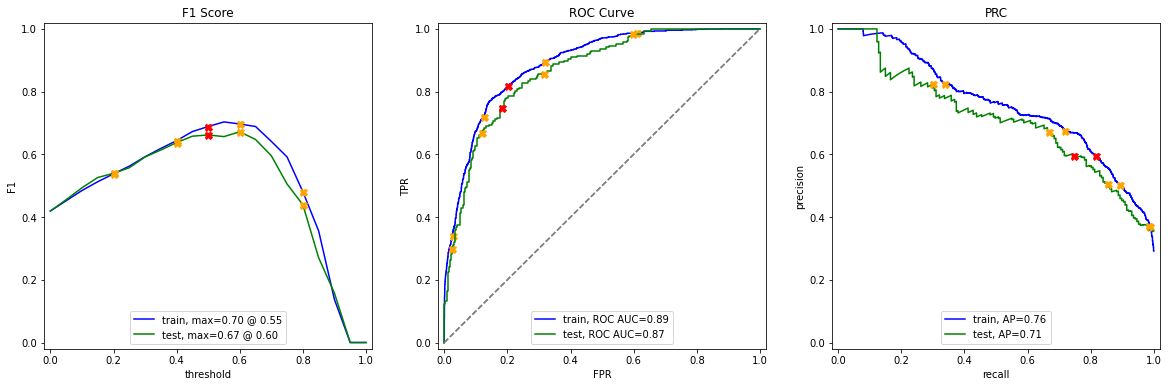

In [56]:
evaluate_model(best_rf2_model, features_train2, target_train2, 
                            features_test2, target_test2)

### CatBoostClassifier Without Target Leakage

In [57]:
cat_features = train_X2.select_dtypes(include=[np.uint8]).columns
cat2 = CatBoostClassifier(learning_rate=0.2, l2_leaf_reg=5, depth=5, loss_function='Logloss',
                        random_seed=42)
best_cb2_model, best_cb2_auc, best_cb2_time = build_model(cat2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'iterations': range(100, 600, 100)
                                                                        }, 
                scoring=roc_scorer, cv=5, model_str='catboost',
           cat_features=cat_features)

0:	learn: 0.5786387	total: 48.8ms	remaining: 4.83s
1:	learn: 0.4967497	total: 51.7ms	remaining: 2.53s
2:	learn: 0.4607849	total: 54.2ms	remaining: 1.75s
3:	learn: 0.4280060	total: 56.8ms	remaining: 1.36s
4:	learn: 0.4096513	total: 59.4ms	remaining: 1.13s
5:	learn: 0.3985206	total: 61.9ms	remaining: 970ms
6:	learn: 0.3882092	total: 64.6ms	remaining: 858ms
7:	learn: 0.3744477	total: 67.2ms	remaining: 772ms
8:	learn: 0.3682270	total: 69.7ms	remaining: 705ms
9:	learn: 0.3646361	total: 72.3ms	remaining: 651ms
10:	learn: 0.3609890	total: 74.9ms	remaining: 606ms
11:	learn: 0.3576056	total: 77.7ms	remaining: 570ms
12:	learn: 0.3545930	total: 80.3ms	remaining: 537ms
13:	learn: 0.3495863	total: 82.8ms	remaining: 509ms
14:	learn: 0.3464561	total: 85.4ms	remaining: 484ms
15:	learn: 0.3447062	total: 88ms	remaining: 462ms
16:	learn: 0.3430537	total: 90.7ms	remaining: 443ms
17:	learn: 0.3412540	total: 93.2ms	remaining: 425ms
18:	learn: 0.3402977	total: 95.8ms	remaining: 409ms
19:	learn: 0.3386470	tot

          train  test
Accuracy   0.98  0.83
F1         0.96  0.64
APS        0.99  0.78
ROC AUC    1.00  0.88


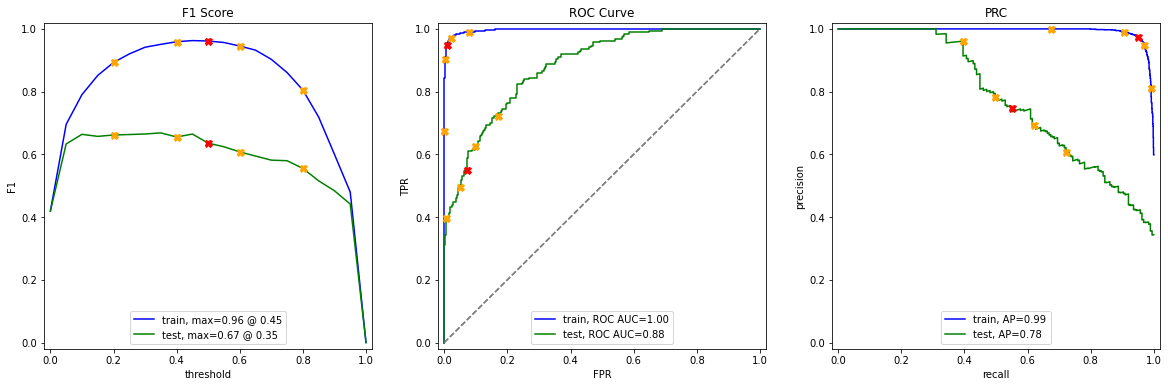

In [58]:
evaluate_model(best_cb2_model, features_train2, target_train2, 
                            features_test2, target_test2)

In [59]:
model_results_df = pd.DataFrame({'model': [
                                           'LogisticRegression2',
                                           'RandomForestClassifier2', 
                                           'CatBoostClassifier2'],
              'best_auc': [best_lr2_auc, best_rf2_auc, best_cb2_auc],
              'train_time': [best_lr2_time, best_rf2_time, best_cb2_time]})

In [60]:
model_results_df

,model,best_auc,train_time
0,LogisticRegression2,0.905839,6.63
1,RandomForestClassifier2,0.866620,170.16
2,CatBoostClassifier2,0.882291,29.16


#### Conclusion
 - Four modles were built:
     - Dummy model
     - LogisticRegression model without leakage
     - RandomForestClassifier without leakage
     - CatBoostClassifier without leakage
 - 5-fold cross validation was used along with GridSearch to search for the best hyperparameters for each modle. For LogisticRegressiion, the best C was found. In the case of RandomForestClassifier, they were n_estimators and max_depth. For CatBoostClassifier it was iterations.
 - The evaluation metric is ROC AUC, and based on this, the LogisticRegression model performed the best. It had both the highst AUC and took the shortest amount of time to train.

### Best Features of Each Model

In [61]:
w0 = best_lr2_model.intercept_[0]
w = best_lr2_model.coef_[0]

In [62]:
lr_feat_importance = pd.DataFrame({'feature': features_train2.columns, 
                                    'importance': np.exp(w)}).sort_values('importance', ascending=False)

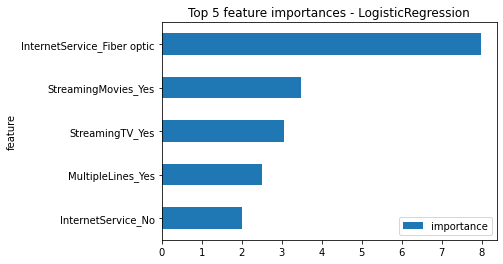

In [63]:
# top five features for LogisticRegression model

lr_feat_importance[:5].plot(kind='barh', x='feature', y='importance')
plt.title('Top 5 feature importances - LogisticRegression')
plt.gca().invert_yaxis()

After removing the leakage, the top five features are related to phone and internet services with `'TotalCharges'` being the odd one.

In [64]:
# top five features for RandomForestClassifier model

rf_feat_importance = pd.DataFrame(best_rf2_model.feature_importances_, 
                                  index=features_train2.columns.tolist(), 
                                 ).sort_values(0, ascending=False).rename(columns={0: 'importance'})

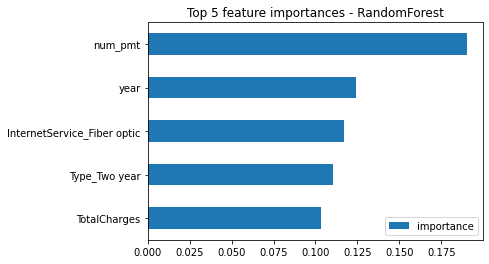

In [65]:
rf_feat_importance[:5].plot(kind='barh', y='importance')
plt.title('Top 5 feature importances - RandomForest')
plt.gca().invert_yaxis()

RandomForest seems to have a completely different picture than LogisticRegression. Here `'num_pmt'`, `'year'`, `'InternetService'`, `'Type'`, and `'TotalCharges'` are the top features.

In [66]:
# top five features of CatBoostClassifier model

cat_feat_importance = pd.DataFrame(best_cb2_model.feature_importances_, 
                                  index=features_train2.columns.tolist(), 
                                 ).sort_values(0, ascending=False).rename(columns={0: 'importance'})

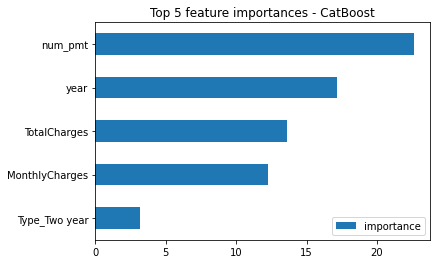

In [67]:
cat_feat_importance[:5].plot(kind='barh', y='importance')
plt.title('Top 5 feature importances - CatBoost')
plt.gca().invert_yaxis()

The CatBoost model has overfitted itself to the train. Some of the topp features are similar to RandomForest.

#### Conclusion
The tree based models clearly differ from the linear models in the way they identify important features. However, some derived features such as `'num_days'` and `'num_payment'` would be tricky to compute for a new csutomer. Therefore, based on the insights the models have shown, it makes sense to stick with the LogisticRegression model.

### Summary
 - The following customer features were engineered:
     - `'num_days'` - dervied by taking the difference between `'EndDate'` and `'BeginDate'`
     - `'num_pmt'` - derived by taking the ratio between `'TotalCharges'` and `'MonthlyCharges'`
     - `'num_services'` - counts a yes for either phone service or internet related service as a 1 or 0, then it is totalled to determine the number of services a customer has signed up for
 - Missing values in the phone and internet related features were replaced with 'No' as these represent customers who did not have these services.
 - Numerical features such as `'MonthlyCharges'`, `'num_days'`, `'num_pmt'`, `'num_service'` and `'TotalCharges'` were scaled on the training set. Similarly, the categorical features and binary features where encoded using one-hot encoding.
 - Redundant features such as `'CustomerId'`, `'BeginDate'`, and `'EndDate'` were dropped and four models were built.
 - Upsampling didn't help with improving the AUC ROC score. However, increasing the train test ratio from 80:20 to 90:10 did help the model improve by 1%.
 - 5-fold CV with Gridsearch was used to identify the suitable hyperparameters for the respective models. For example, in LogisticRegression C was tuned. For RandomForest, it was n_estimators and max_depth. Iterations was tuned for CatBoost.
 - The best model in terms of ROC-AUC and time to train the model is LogisticRegression with a AUC of 91% on the test set and a training time of less than 7 seconds.
- The marketing team of the telco can use this model to identify churn. In addition, they can improve the signal by adding features around usage of various plans, location of customer, customer complaints, time to resolve them, etc.

## Solution Report
 - What steps of the plan were performed and what steps were skipped (explain why)?
 - What difficulties did you encounter and how did you manage to solve them?
 - What were some of the key steps to solving the task?
 - What is your final model and what quality score does it have?

### The following steps were performed:

1. Exploratory analysis around gender, senior citizen and characteristics of the customers have revealed some useful insights into this question, and it uncovered some useful insights into the behaviour of churned customers.
 - For some of them, the mean monthly spend for a churned customer is higher by //$13 compared with an active customer.
 - 1,037 (47%) of the customers who sign up in the first year churn.
 - Other behavior noted among the churned customers are:
     - Customers with no dependents or partners tend to easily churn.
     - Monthly billing gives them an easy exit option.
     - Paperless billing and Fiber optic internet plan have been a thorn in retaining such customers.
2. The missing values in `'TotalCharges'` were imputed using SimpleImputer. Initially, I thought I would infer them based on the `'MonthlyCharges'`, but I noticed that the monthly charges even for the same duration and set of services differ slightly. Imputation didn't shift the median much. I also imputed the "missing" values for `'MultipleLines'` and various Internet services after merging the datasets with a response of "No", since this meant the customer did not opt for these services.
 - I skipped the idea of imputing them using LogisticRegression as it would have been overkill for this problem.
3. In the feature engineering step, I created `'num_day'` derived by taking the difference between `'EndDate'` and `'BeginDate'`. Additionally, I created `'num_pmt'` which is a ratio of `'TotalCharges'`/`'MonthlyCharges'`. `'num_services'`, which adds up the various services for a customer depending on whether they've answered "Yes" or "No".
4. To avoid data leakage, I stratfied and split the dataset into train and test into a ratio of 80:20. I create a copy of this dataset, as I wanted to test whether `'num_days'` caused any leakage; I applied Oridinal Encoding for the Type and PaymentMethod features.
     - I also scaled the numerical features such as `'num_days'`, `'num_pmt'`, `'num_services'`, `'MonthlyCharges'`, `'TotalCharges'`, including the date features.
     - I One-hot encoded the boolean features.
5. Excluding the Dummy model, I built six models using LogisticRegression, RandomForestClassifier and CatBoostClassifier. Each model was trained on the two datasets.
     - I used 5-fold cross validation during GridSearch to identify useful hyperparameters for the respective models. Only one or twp hyperparameters were tuned to save time.
     - With leakage, the LogisticRegression model and CatBoost hit 99% AUC ROC on the test-set. Although the former completed 20x faster.

### Steps skipped
1. Upsampling because this only slightly improved the AUC, and after a point was causing the RandomForest and CatBoost to overfit to the train set.
2. `'num_days'`, `'month'` and `'dayofweek'` didn't have much signal strength relative to `'num_pmt'` and `'year'`.
3. Imputation using LogisticRegression, as this would have been overkill.

### Challenges

 - The difficulties I encountered were after I removed the target leaked features such as `'num_days'`, `'num_pmt'`, `'year'`, `'month'` and `'dayofweek'` all in one go.
     - I removed `'num_pmt'`, `'num_days'` and the Date features `'year'`, `'month'` and 
     `'dayofweek'`, and retrained the model. This drastically reduced the score for LogisticRegression, which returned an AUC score 85%; the other models seem to overfit.
     - To address this, I added upsampling to the mix and changed the upsampling ratio, however, it only ended up overfitting the RandomForest and CatBoost models, and it helped the LogisticRegression models' AUC score to go up by 1%.
     - I changed the Ordinal features to use One-hot encoding, but that didn't help improve the performance.
    - I changed the train/test split to 90:10, and noticed a slight improvement.
    - I played with additional hyperparameters in RandomForest and CatBoost such as max_depth/depth, min_sample_leafs/l2_leaf_reg. min_sample_leafs helped reduce overfitting in RandomForest significantly, but l2_leaf_reg didn't help reduce overfitting. And a similar argument in CatBoost threw an error stating that the feature is not supported on CPU.
     - I decided to reuse only `'month'` and `'dayofweek'` along with `'num_pmt'` and `'num_days'`. Surprisingly, this helped increase the AUC to 87% using LogisticRegression.
     - I dropped upsampling from the mix, and removed `'dayofweek'` to see if this would affect the score, but it didn't.
     - This time, I dropped `'month'`, `'dayofweek'` and `'num_days'`. I re-introduced `'year'` into the mix along with `'num_pmt'`, and this boosted my AUC score to 91% using LogisticRegression; The RandomForestClassifier's performance also improved with slight overfitting. However, CatBoost was severly overfitting although the AUC had improved on the test set.
     - What worked was increasing the train-test split to 90:10, removing `'num_days'`, `'month'`, and `'dayofweek'`, and retaining `'num_pmt'` and `'year'` with the other one-hot encoded features. Upsampling didn't help to improve the performance beyond this point.

### Key Steps Taken
1. Feature engineering - Finding a golden feature which improves the signal to noise ratio helped me a lot.
2. Playing with train-test split also helped.
3. Avoiding leakage by splitting the data into train/test before scaling and applying ordinal enconding also helped.
4. Hyperparameter tuning along with 5-fold cross validation made me comfortable knowing that the model would generalize better to new data.
5. EDA also helped.

### Final model
Because of the choice of features, I was able to build a simple model using LogisticRegression which achieved an AUC ROC score of 91% on the test set. This model took about 7 seconds to train, and didn't overfit.